# Trajectory Run 03
- This new set corrects the angular generation error: generate uniform $\phi$ and uniform $\cos \theta$
- The procedure is exactly the same as Run 01-02 but now uses the modeleval tool.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from mu2e import mu2e_ext_path
from mu2e.dataframeprod import DataFrameMaker
from mu2e.mu2eplots import mu2e_plot, mu2e_plot3d
from matplotlib import gridspec
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import math
import pandas as pd
from time import sleep
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from skhep.visual import MplPlotter as splt
from copy import deepcopy
from lmfit import Model, Parameters, report_fit
from hallprobesim_redux import *
from tqdm import tnrange, tqdm_notebook
#import pandas as pd
import seaborn as sns
from datetime import datetime
import time

In [4]:
init_notebook_mode(True)

In [5]:
from subprocess import call
import json
import plotly.utils
from plotly.offline import iplot, plot
from sys import getsizeof
import pickle as pkl

In [6]:
#from mu2e.tools.fiteval import get_mag_field_function
#import odespy
from mu2e.tools.particletransport import ElectronSwimmer

In [7]:
from mu2e.tools.modeleval import get_mag_field_function

In [8]:
mag_field_func = get_mag_field_function('Mau13traj',units=('mm','T'),fastcart=True)

recreating fit with func_version=1000,
cfg_params(pitch1=0, ms_h1=0, ns_h1=0, pitch2=0, ms_h2=0, ns_h2=0, length1=10, ms_c1=50, ns_c1=4, length2=0, ms_c2=0, ns_c2=0, ks_dict={'k3': 10000}, bs_tuples=None, bs_bounds=None, version=1000)
Elapsed time was 1.22921 seconds
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 0
    # data points      = 46560
    # variables        = 0
    chi-square         = 764307.395
    reduced chi-square = 16.4155368
    Akaike info crit   = 130285.508
    Bayesian info crit = 130285.508
[[Variables]]
    pitch1:    0 (fixed)
    ms_h1:     0 (fixed)
    ns_h1:     0 (fixed)
    pitch2:    0 (fixed)
    ms_h2:     0 (fixed)
    ns_h2:     0 (fixed)
    length1:   10 (fixed)
    ms_c1:     50 (fixed)
    ns_c1:     4 (fixed)
    length2:   0 (fixed)
    ms_c2:     0 (fixed)
    ns_c2:     0 (fixed)
    Ac1_0_0:  -74613.8 (fixed)
    Bc1_0_0:   13334 (fixed)
    Dc1_0:     0.9452835 (fixed)
    Ac1_0_1:  -439.0484 (fixed)
    Bc1_0_

## Gen Run 03

In [27]:
str(datetime.now())

'2019-05-07 13:17:30.328452'

In [9]:
# import data (first prepped in python 2)
df = pd.read_pickle(mu2e_ext_path+'root/ce_OLD.pkl')
# select good events only
df = df[df['de._status'] != -1000]

In [10]:
df = df.sample(n=100).reset_index(drop=True)

df['X0'] = df['demcgen_x']
df['Y0'] = df['demcgen_y']
df['Z0'] = df['demcgen_z']+10200.

df = df[['X0','Y0','Z0']]

#df

#Great, now let's generate random theta and phi (from standard spherical coordinates) to denote the direction of the momentum vector. The magnitude is always 105 MeV!

#df['Phi0'] = np.random.uniform(0,2*np.pi,200)
df['Phi0'] = np.random.uniform(0,2*np.pi,100)

#df['Theta0'] = np.random.uniform(0,np.pi,200)
#df['Theta0'] = np.random.uniform(0,np.pi,100)
# FIXED THETA
df['CosTheta0'] = np.random.uniform(-1,1,100)
df['Theta0'] = np.arccos(df['CosTheta0'])

mom = 105.

df['Px0'] = mom * np.sin(df['Theta0'])*np.cos(df['Phi0'])
df['Py0'] = mom * np.sin(df['Theta0'])*np.sin(df['Phi0'])
df['Pz0'] = mom * np.cos(df['Theta0'])
df['Pt0'] = mom * np.sin(df['Theta0'])

#Let's check out our generated starting conditions!

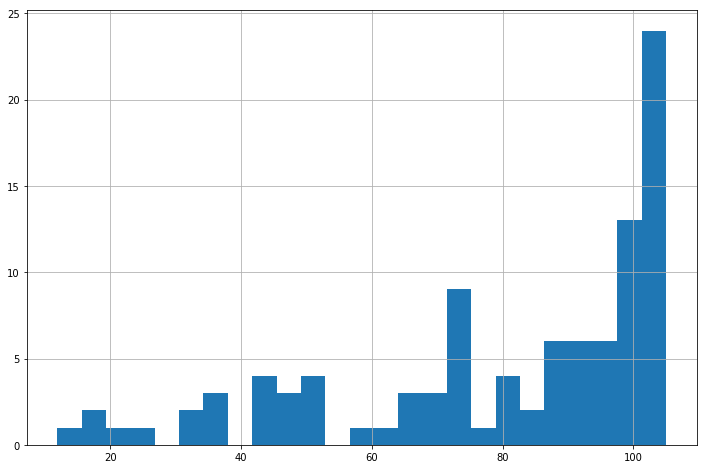

In [11]:
df.Pt0.hist(bins=25)

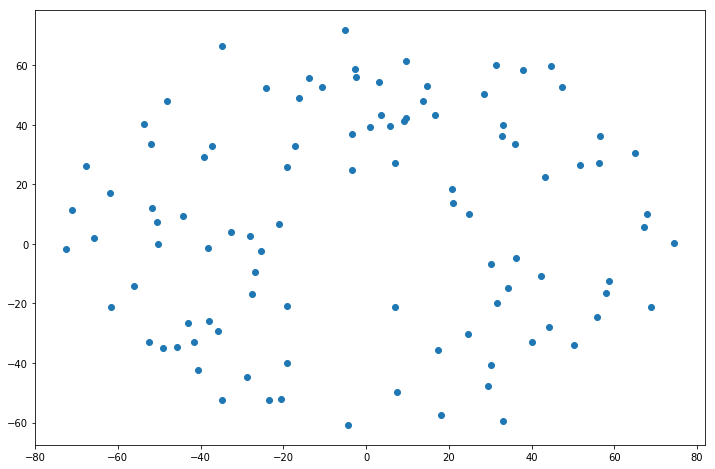

In [12]:
plt.scatter(x=df.X0,y=df.Y0)

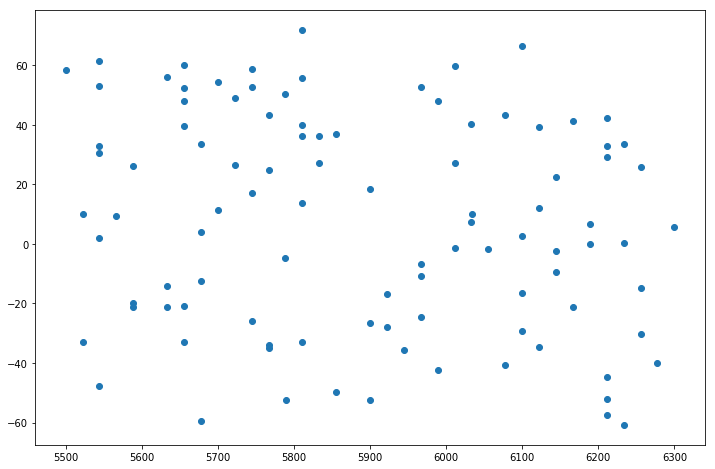

In [13]:
plt.scatter(x=df.Z0,y=df.Y0)

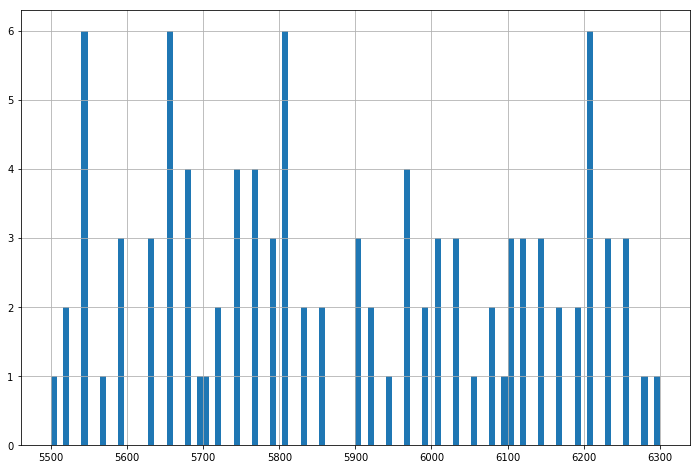

In [14]:
df.Z0.hist(bins=100)

In [42]:
df

,X0,Y0,Z0,Phi0,CosTheta0,Theta0,Px0,Py0,Pz0,Pt0
0,-14.647705,37.616524,5899.977539,1.099080,0.143399,1.426901,47.220498,92.566266,15.056922,103.914817
1,23.620117,23.873680,5722.189941,6.090903,0.494710,1.053295,89.569399,-17.438048,51.944559,91.251098
2,-9.940674,66.988113,5766.657715,1.065133,0.239092,1.329366,49.385568,89.195414,25.104658,101.954677
3,38.080566,1.296604,6100.037109,2.087748,0.675679,0.828911,-38.256335,67.291008,70.946269,77.405600
4,34.759766,3.226178,5566.687012,1.108421,0.643033,0.872344,35.870254,71.969286,67.518492,80.413016
5,-28.667969,-36.301380,5811.079590,6.026849,-0.614701,2.232804,80.113697,-20.997954,-64.543641,82.819795
6,66.123047,25.369076,5722.238770,4.664505,-0.348496,1.926763,-4.710785,-98.304765,-36.592098,98.417571
7,53.149902,33.059135,5500.024414,4.035997,-0.342071,1.919917,-61.763168,-76.943125,-35.917496,98.665766
8,9.153076,35.646210,5944.477539,0.452865,-0.961317,2.862540,26.006304,12.654490,-100.938278,28.921687
9,-11.272949,20.334005,5611.120605,1.557317,0.615467,0.907818,1.115498,82.749568,64.624026,82.757086


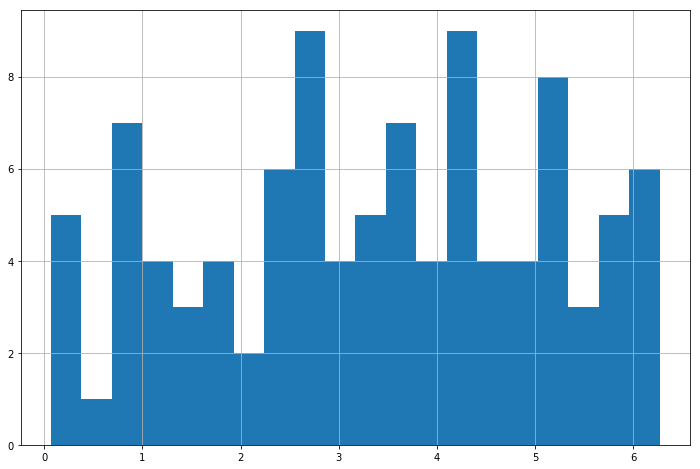

In [15]:
df.Phi0.hist(bins=20)

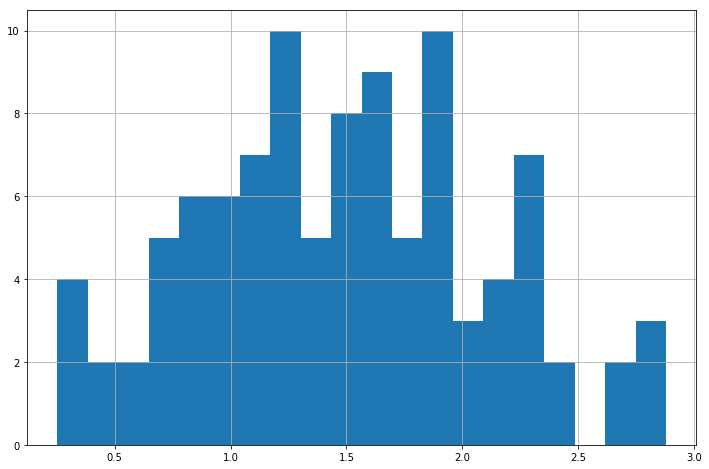

In [44]:
df.Theta0.hist(bins=20)

Let's also dump the generating dataframe to pickle:

In [9]:
save_dir = "/home/ckampa/Coding/Mu2E_Extras/trajectory/run03/"
run_name = "trajectory_run03_10e-11step_Dop853_"

In [46]:
pkl.dump(df, open(save_dir+run_name+'INIT_COND.p','wb'))

Now we are ready to go!

In [29]:
#timesteps = np.linspace(0,4e-8,4000)
timesteps = np.linspace(0,4e-8,4000)

In [30]:
start = time.time()
for i,row in tqdm_notebook(enumerate(df.iloc[[1]].itertuples()), desc='particle #'):
    #print (i, row.X0)
    mom = np.array([row.Px0,row.Py0,row.Pz0])
    pos = np.array([row.X0,row.Y0,row.Z0])
    rtol = 1e-5
    atol = 1e-3
    swimmer = ElectronSwimmer(mom,pos,mag_field_func,timesteps,'Dop853',rtol=rtol,atol=atol)
    #swimmer = ElectronSwimmer(mom,pos,mag_field_func,timesteps,'Dop853',rtol=rtol,atol=atol)
    X, t = swimmer.solve()
    df_out = pd.DataFrame(X,columns=['X','Y','Z','Vx','Vy','Vz'])
    df_out['time'] = t
    df_out['event'] = i
    df_out.event = df_out.event.astype('category')
    df_out['E0'] = swimmer.init_E
    df_out['EF'] = swimmer.final_E
    pkl.dump(df_out,open(save_dir+run_name+f"{i:03d}_TESTING.p",'wb'))
stop = time.time()

swimming electron with [ 89.17044479 -54.03255115  12.41431398] MeV, starting at [ -23.57373047  -52.28263855 5788.93701172] mm, for 4e-08 s
init energy: 105.00124342646296 MeV
final energy: 105.53504499774861 MeV
energy difference: 0.5338015712856503 MeV (0.5084%)



Only had time for 75 particles before FMS #53.

In [58]:
# testing it all worked for 1
df_out = pkl.load(open(save_dir+run_name+'000.p','rb'))

In [59]:
df_out

,X,Y,Z,Vx,Vy,Vz,time,event,E0,EF
0,-14.647705,37.616524,5899.977539,1.348208e+11,2.642890e+11,4.298951e+10,0.000000e+00,0,105.001243,109.43521
1,-13.315936,40.268547,5900.407514,1.314621e+11,2.659765e+11,4.298407e+10,1.000250e-11,0,105.001243,109.43521
2,-12.017866,42.937235,5900.837437,1.280827e+11,2.676210e+11,4.297897e+10,2.000500e-11,0,105.001243,109.43521
3,-10.753699,45.622158,5901.267310,1.246832e+11,2.692224e+11,4.297419e+10,3.000750e-11,0,105.001243,109.43521
4,-9.523634,48.322881,5901.697136,1.212641e+11,2.707804e+11,4.296972e+10,4.001000e-11,0,105.001243,109.43521
5,-8.327865,51.038970,5902.126920,1.178259e+11,2.722947e+11,4.296554e+10,5.001250e-11,0,105.001243,109.43521
6,-7.166579,53.769987,5902.556663,1.143693e+11,2.737651e+11,4.296164e+10,6.001500e-11,0,105.001243,109.43521
7,-6.039957,56.515491,5902.986368,1.108947e+11,2.751915e+11,4.295800e+10,7.001750e-11,0,105.001243,109.43521
8,-4.948178,59.275041,5903.416039,1.074028e+11,2.765735e+11,4.295462e+10,8.002001e-11,0,105.001243,109.43521
9,-3.891410,62.048193,5903.845676,1.038941e+11,2.779111e+11,4.295147e+10,9.002251e-11,0,105.001243,109.43521


In [8]:
from hallprobecalib.hpcplots import scatter2d, scatter3d, histo

In [31]:
scatter3d(df_out.X,df_out.Y,df_out.Z,scale_list=[df_out.time],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

Figure({
    'data': [{'marker': {'cauto': False,
                         'cmax': 4e-08,
                         'cmin': 0.0,
                         'color': array([0.00000000e+00, 1.00025006e-11, 2.00050013e-11, ..., 3.99799950e-08,
                                         3.99899975e-08, 4.00000000e-08]),
                         'colorbar': {'thickness': 20, 'title': 'time (mm)', 'x': -0.1, 'y': 0.5},
                         'colorscale': 'Viridis',
                         'opacity': 0.8,
                         'reversescale': False,
                         'showscale': True,
                         'size': 2},
              'mode': 'markers+lines',
              'name': '<br>x: X (mm)<br>y: Y (mm)<br>z: Z (mm)<br>',
              'type': 'scatter3d',
              'uid': 'cecb65f5-9129-490d-8709-d6e71459b0d6',
              'x': array([-23.57373047, -21.01726607, -18.44129515, ...,  77.04929463,
                           79.98150141,  82.91537939]),
              'y': ar

Great! But this takes far too long...bottlenecked by B-field calculation.

In [32]:
%timeit mag_field_func(10,10,6000)

2.01 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Goal: beat this down by a factor of 10.

In [10]:
df_out = pkl.load(open(save_dir+run_name+'000_TESTING.p','rb'))

In [11]:
df_out.eval('R = (X**2+Y**2)**(1/2)',inplace=True)

In [14]:
df_small = df_out[::10]

In [15]:
df_small

,X,Y,Z,Vx,Vy,Vz,time,event,E0,EF,R
0,-23.573730,-52.282639,5788.937012,2.545934e+11,-1.542701e+11,3.544451e+10,0.000000e+00,0,105.001243,105.535045,57.351504
10,2.816048,-66.027968,5792.486285,2.723335e+11,-1.201915e+11,3.552221e+10,1.000250e-10,0,105.001243,105.535045,66.087992
20,30.755000,-76.261180,5796.042973,2.855288e+11,-8.414201e+10,3.559247e+10,2.000500e-10,0,105.001243,105.535045,82.229177
30,59.777532,-82.814843,5799.606342,2.939713e+11,-4.672125e+10,3.565625e+10,3.000750e-10,0,105.001243,105.535045,102.135457
40,89.401070,-85.582784,5803.175886,2.975308e+11,-8.551517e+09,3.571640e+10,4.001000e-10,0,105.001243,105.535045,123.761723
50,119.134029,-84.521723,5806.751368,2.961578e+11,2.973376e+10,3.577530e+10,5.001250e-10,0,105.001243,105.535045,146.071347
60,148.483954,-79.651819,5810.332747,2.898842e+11,6.750124e+10,3.583454e+10,6.001500e-10,0,105.001243,105.535045,168.498952
70,176.965662,-71.056176,5813.920114,2.788232e+11,1.041275e+11,3.589516e+10,7.001750e-10,0,105.001243,105.535045,190.698258
80,204.109236,-58.879294,5817.513643,2.631665e+11,1.390101e+11,3.595784e+10,8.002001e-10,0,105.001243,105.535045,212.431993
90,229.467750,-43.324503,5821.113562,2.431817e+11,1.715763e+11,3.602298e+10,9.002251e-10,0,105.001243,105.535045,233.521864


In [16]:
df = df_small
scatter3d(df.X,df.Y,df.Z,scale_list=[df.time],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

Figure({
    'data': [{'marker': {'cauto': False,
                         'cmax': 3.990997749437359e-08,
                         'cmin': 0.0,
                         'color': array([0.00000000e+00, 1.00025006e-10, 2.00050013e-10, ..., 3.97099275e-08,
                                         3.98099525e-08, 3.99099775e-08]),
                         'colorbar': {'thickness': 20, 'title': 'time (mm)', 'x': -0.1, 'y': 0.5},
                         'colorscale': 'Viridis',
                         'opacity': 0.8,
                         'reversescale': False,
                         'showscale': True,
                         'size': 2},
              'mode': 'markers+lines',
              'name': '<br>x: X (mm)<br>y: Y (mm)<br>z: Z (mm)<br>',
              'type': 'scatter3d',
              'uid': '2b4c1028-cac2-49ea-a996-42daf29243ea',
              'x': array([-23.57373047,   2.81604756,  30.75499985, ...,  -0.54512077,
                           27.70835526,  56.5924291 ]),
     

In [17]:
df_small.head(1)

,X,Y,Z,Vx,Vy,Vz,time,event,E0,EF,R
0,-23.57373,-52.282639,5788.937012,2.545934e+11,-1.542701e+11,3.544451e+10,0.0,0,105.001243,105.535045,57.351504


In [18]:
(df_small.head(1).EF-df_small.head(1).E0)/df_small.head(1).E0

0    0.005084
dtype: float64

In [22]:
mom = [89.17044479,-54.03255115,12.41431398]
p = np.sqrt(np.dot(mom,mom))
pt = np.sqrt(mom[0]**2+mom[1]**2)

In [21]:
p

104.99999999722775

In [23]:
pt

104.26353536986842